# Sequential Monte Carlo on a Non-Markovian Gaussian State-Space model

We We consider a non-Markovian Gaussian sequence model (NM-GSM) of the form

$$
\begin{aligned}
    f_t(x_t \vert x_{t-1}) &= \mathcal{N}(x_t \vert \phi x_{t-1}, q),\\
    g_t(y_t \vert x_{1:t}) &= \mathcal{N}\left(y_t, \sum_{k=1}^t \beta^{t-k} x_k, r\right)
\end{aligned}
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import distrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jsmc.datagen import non_markovian_gsm as nmgsm
from jsmc.samplers import sequential_monte_carlo as smc

In [3]:
plt.rcParams["figure.figsize"] = [6.4, 4.0]
%config InlineBackend.figure_format = "retina"

## Sampling NM-GSM

In [4]:
key = jax.random.PRNGKey(3141)
key_sample, key_filter = jax.random.split(key)

num_steps = 100
# params = nmgsm.ModelParameters(phi=0.0, q=1.0, beta=0.0, r=0.2)
params = nmgsm.ModelParameters(phi=1.0, q=1.0, beta=0.5, r=1.0)
simulation = nmgsm.simulate(key_sample, params, num_steps)

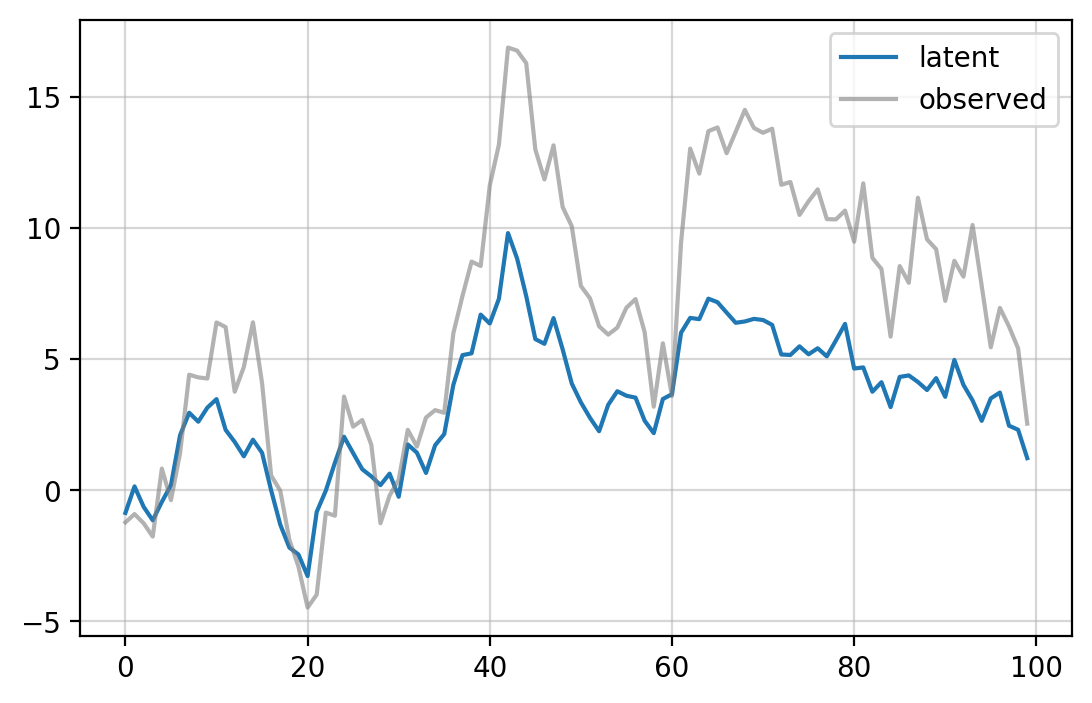

In [5]:
plt.plot(simulation.x, label="latent")
plt.plot(simulation.y, label="observed", c="tab:gray", alpha=0.6)
plt.legend()
plt.grid(alpha=0.5)

In [6]:
class BootstrapProposal:
    def __init__(self, params: nmgsm.ModelParameters):
        self.params = params
    
    def sample(self, key, particle_cond, step, _):
        phi = self.params.phi
        q = self.params.q
        last_val = particle_cond[step]
        
        eps = jax.random.normal(key)
        value = phi * last_val + jnp.sqrt(q) * eps
        return value
    
    def logpdf(self, x, particles, step):
        phi = self.params.phi
        q = self.params.q
        last_sample = particles[step]
        
        dist_norm = distrax.Normal(loc=last_sample * phi, scale=jnp.sqrt(q))
        return dist_norm.log_prob(x)
    
    
class Target:
    def __init__(self, params: nmgsm.ModelParameters):
        self.params = params
    
    def logpdf(self, particles, step, obs):
        num_obs = len(obs)
        particles = particles.squeeze()
        indv = jnp.arange(num_obs) <= step
        log_likelihood = nmgsm.log_joint(particles, obs, self.params)
        log_likelihood = jnp.einsum("n,n->", log_likelihood, indv)
        return log_likelihood

In [92]:
num_particles = 150
dim_particle = 1

proposal = BootstrapProposal(params)
target = Target(params)


state_init = smc._init_state(num_particles, num_steps, dim_particle)

# Initialise particles
particles_init = jax.random.normal(key_filter, (num_particles,)) * jnp.sqrt(params.q)
particles = state_init.particles.at[:, 0, 0].set(particles_init)
state_init = state_init.replace(particles=particles)

# Initialise weights
logt1 = jax.vmap(target.logpdf, (0, None, None))(state_init.particles, 1, simulation.y)
logp1 = distrax.Normal(loc=0, scale=jnp.sqrt(params.q)).log_prob(particles_init)
logw_init = logt1 - logp1
state_init = state_init.replace(log_weights=logw_init, step=0)

/home/gerardoduran/mambaforge/lib/python3.10/site-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)


In [93]:
keys_filter = jax.random.split(key_filter, num_steps)

def step(state, key):
    state = smc.step_and_update(key, state, simulation.y, proposal, target)
    return state, state.log_weights

In [94]:
state, logw_hist = jax.lax.scan(step, state_init, keys_filter)
particles = state.particles

# particles = jnp.roll(state.particles, 1, axis=1).at[:, 0, :].set(state_init.particles[:, 0, :])
logw_hist = jnp.roll(logw_hist, 1, axis=0).at[0].set(state_init.log_weights)

w_hist = jnp.exp(logw_hist - jax.nn.logsumexp(logw_hist, axis=-1, keepdims=True))

In [97]:
nmgsm.log_joint(simulation.x, simulation.y, params).sum()

DeviceArray(-277.50723, dtype=float32)

In [98]:
mll_est = jax.nn.logsumexp(logw_hist, b=1/num_particles, axis=-1)
mll_true = nmgsm.log_joint(simulation.x, simulation.y, params)

In [99]:
sum(mll_est)

DeviceArray(-208.60336, dtype=float32)

In [100]:
target.logpdf(simulation.x, num_steps, simulation.y)

DeviceArray(-277.50723, dtype=float32)

In [101]:
print("Final MLL")
print(f"true: {sum(mll_true):0.4f}")
print(f"smc:  {sum(mll_est):0.4f}")

Final MLL
true: -277.5072
smc:  -208.6034


In [102]:
particles = state.particles.squeeze()
mll_est2 = jax.vmap(nmgsm.log_joint, (0, None, None))(particles, simulation.y, params)
mll_est2 = jnp.einsum("st,ts->t", mll_est2, w_hist)
sum(mll_est2)

DeviceArray(-293.39517, dtype=float32)

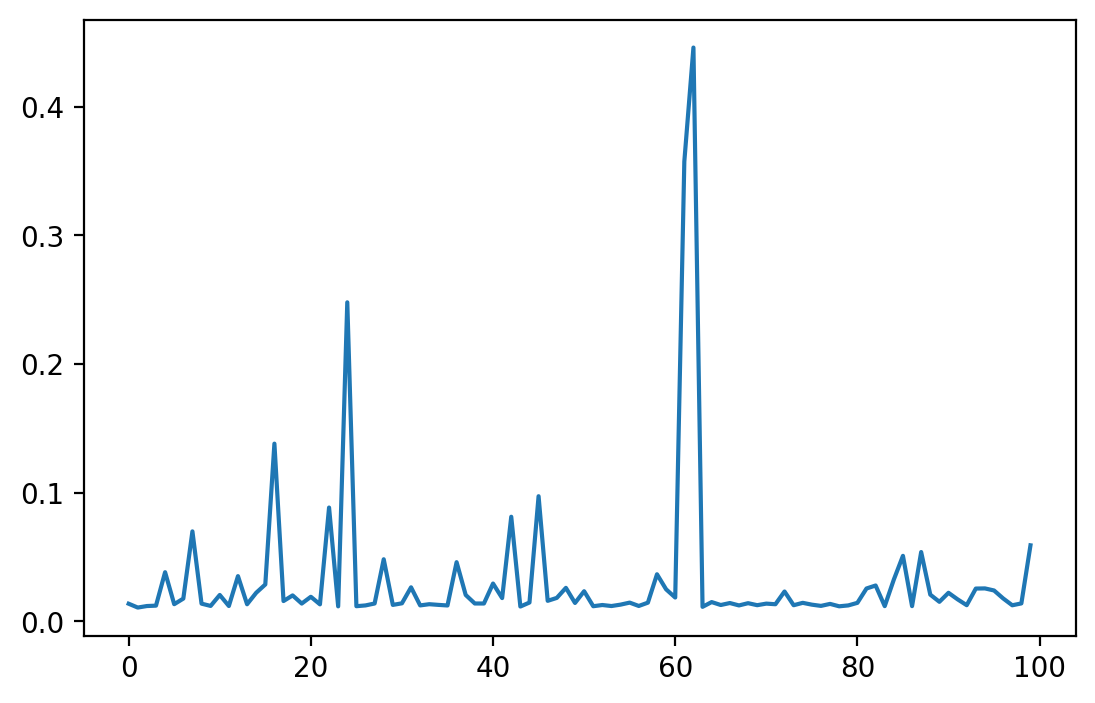

In [103]:
plt.plot(w_hist.max(axis=-1))

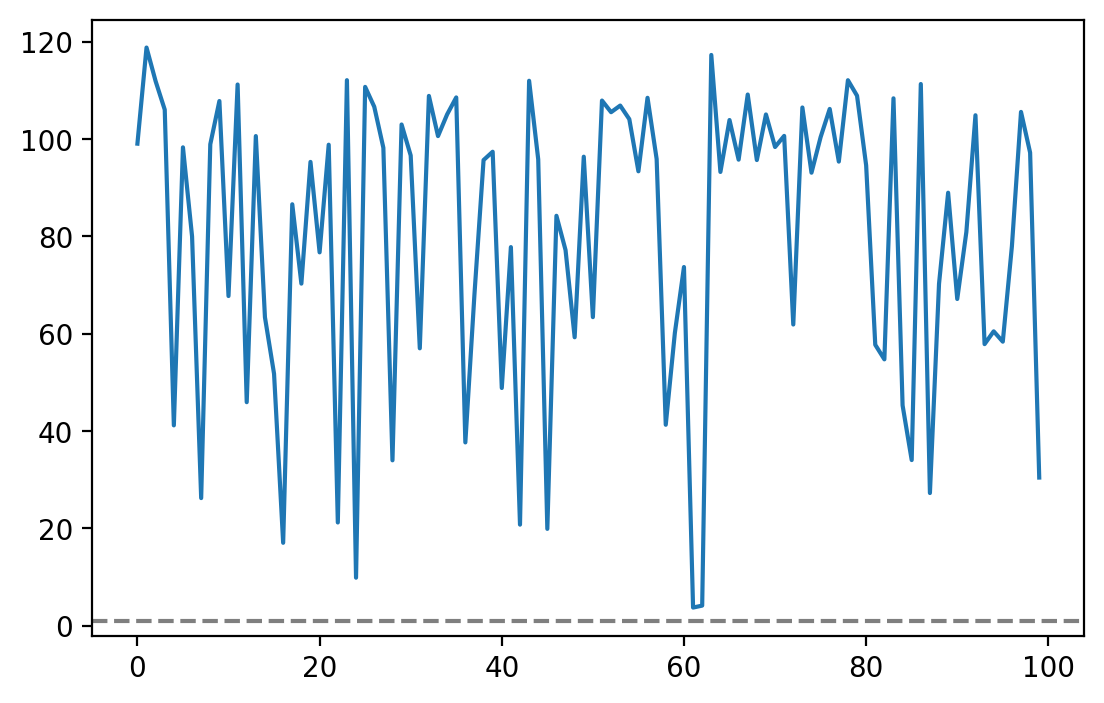

In [104]:
# Effective sample size
ess = 1 / jnp.power(w_hist, 2).sum(axis=-1)
plt.plot(ess)
plt.axhline(y=1, c="tab:gray", linestyle="--")

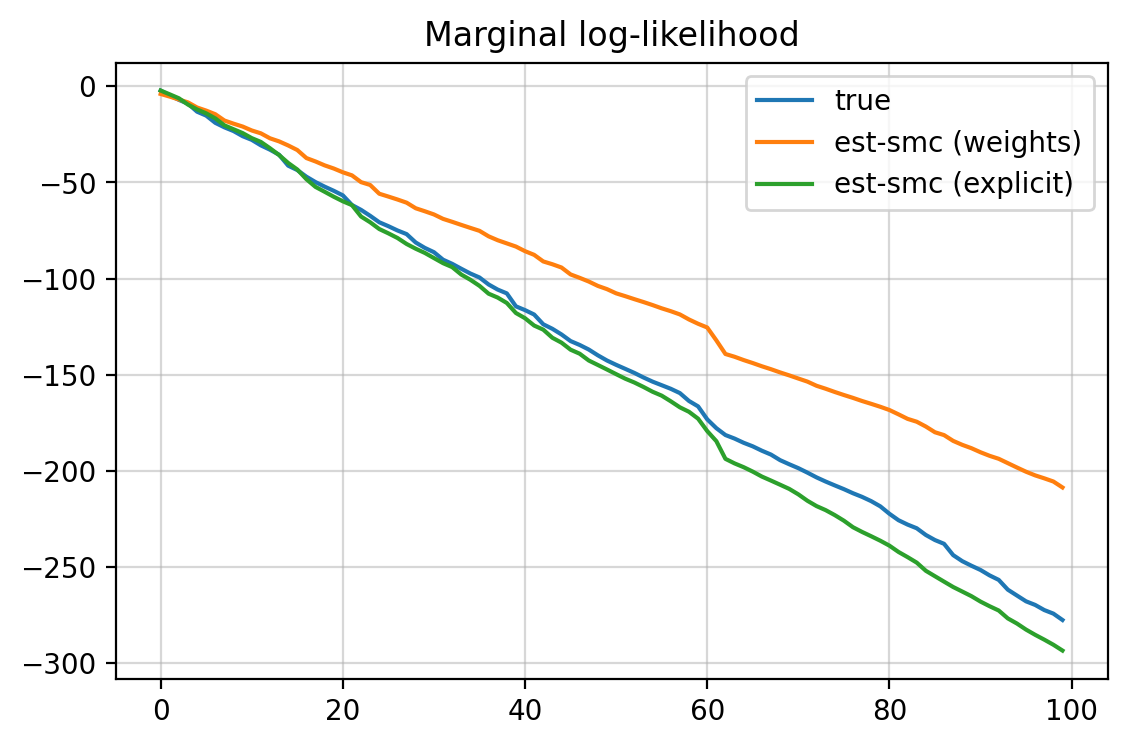

In [105]:
plt.plot(mll_true.cumsum(), label="true")
plt.plot(mll_est.cumsum(), label="est-smc (weights)")
plt.plot(mll_est2.cumsum(), label="est-smc (explicit)")
plt.legend()
plt.title("Marginal log-likelihood")
plt.grid(alpha=0.5)

## Comparing posterior mean with ground truth

In [109]:
weights = w_hist[-1]
xhat = jnp.einsum("s,st...->t", weights, particles)
xhat_filtered = jnp.einsum("ts,st->t", w_hist, particles)
xhat_uniform = particles.mean(axis=0)

In [122]:
particles[100]

DeviceArray([-0.7033, -0.1491, -0.1353,  0.7132, -0.2286,  0.223 ,
              1.669 ,  2.2887,  1.9496,  2.5064,  3.5137,  3.3115,
              1.4631,  3.9511,  1.9926,  2.3482, -0.3693, -1.5349,
             -1.2778, -2.5488, -2.1693, -1.5108,  1.0973,  1.1988,
              1.748 ,  0.6547,  0.9731,  0.1948, -0.8675, -0.0829,
              0.6541,  0.605 ,  0.5156,  0.9671,  1.4576,  3.2602,
              3.3386,  3.9017,  3.6321,  5.7599,  7.3841,  8.3721,
              9.1465,  8.2894,  7.6271,  5.9414,  5.5395,  5.0889,
              5.3212,  4.0265,  2.8787,  3.0896,  3.2988,  3.229 ,
              4.2808,  3.5379,  2.0666,  1.9407,  0.9483,  2.6857,
              2.7376,  5.0945,  6.0198,  7.3442,  7.2098,  7.7788,
              7.113 ,  6.9161,  7.2544,  6.0185,  7.0223,  6.2006,
              5.5086,  5.8284,  4.6029,  5.2566,  4.4191,  4.5914,
              4.978 ,  4.7583,  5.726 ,  6.0779,  3.4789,  3.4586,
              2.3687,  4.0406,  5.552 ,  4.5388,  5.4355,  4.4

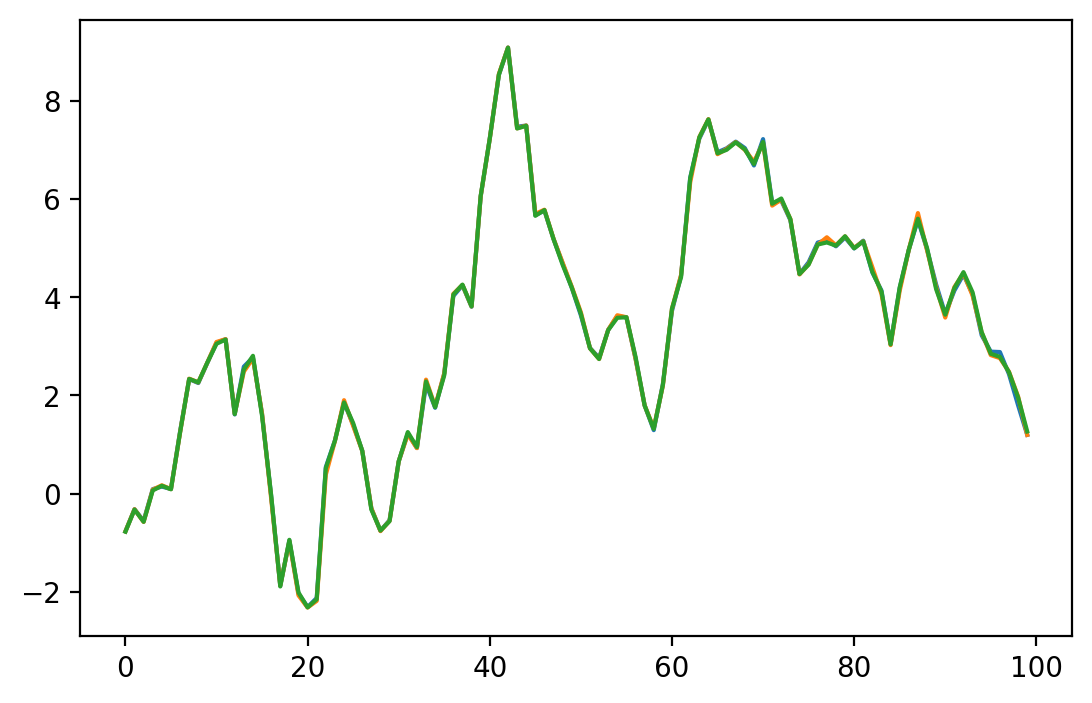

In [123]:
plt.plot(xhat)
plt.plot(xhat_filtered)
plt.plot(xhat_uniform)

Text(0.5, 0.98, 'Posterior estimation comparisson')

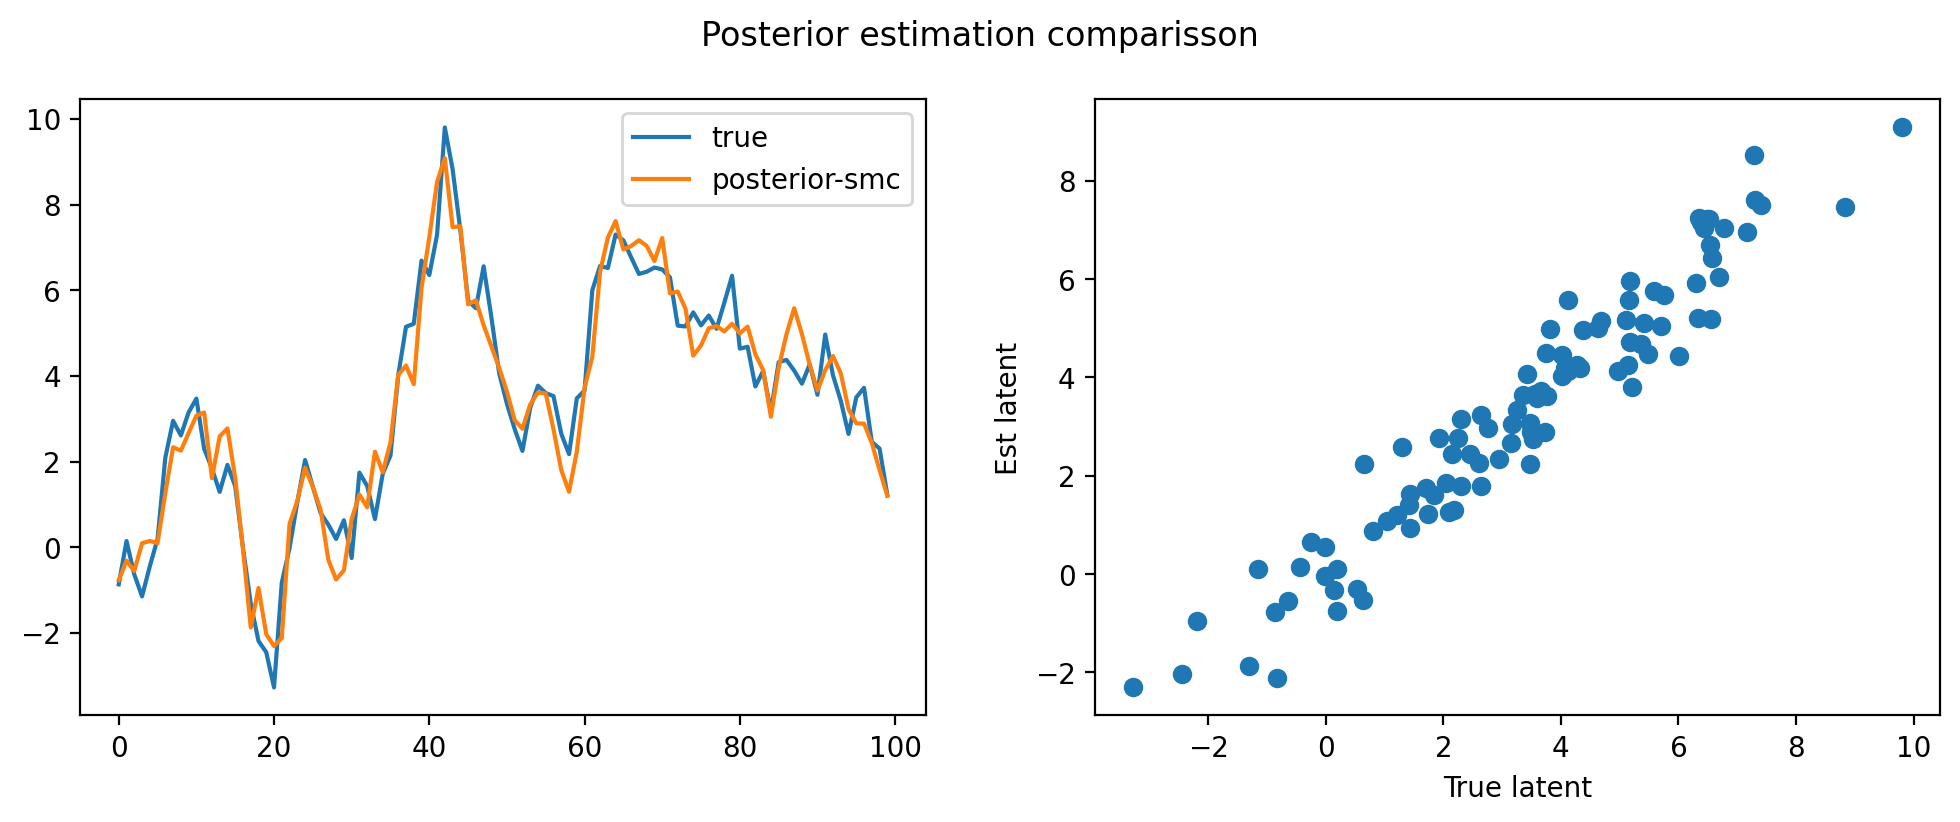

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(simulation.x, label="true")
ax[0].plot(xhat, label="posterior-smc")
ax[0].legend()

ax[1].scatter(simulation.x, xhat)
ax[1].set_xlabel("True latent")
ax[1].set_ylabel("Est latent")

plt.suptitle("Posterior estimation comparisson")